# VWAP Profile Part II

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import pandas as pd
from sklearn import linear_model as linear_model

from getstock import *

matplotlib.rcParams[ 'figure.figsize' ] = ( 14, 6 )

# data source: alphavantage.co|

In [2]:
ticker = "NKE"
raw_bar_data = getMinuteStockPrices(ticker)
raw_bar_data

,open,high,low,close,volume
timestamp,,,,,
2020-03-23 09:31:00,65.705,65.705,65.705,65.7050,0
2020-03-23 09:32:00,65.980,65.990,65.050,65.0750,609387
2020-03-23 09:33:00,66.145,66.145,66.145,66.1450,39270
2020-03-23 09:34:00,65.900,66.260,65.410,65.8251,30441
2020-03-23 09:35:00,65.685,65.810,65.120,65.1200,60463
...,...,...,...,...,...
2020-03-27 15:56:00,83.150,83.550,83.150,83.4350,124235
2020-03-27 15:57:00,83.430,83.460,83.180,83.2000,103459
2020-03-27 15:58:00,83.200,83.440,83.110,83.3200,128523


In [3]:
# add a minute bin
# US start of date, calc in minutes
start_of_day = (9 * 60) + 30
# get the time for each bin in minutes and subtract 9:30
raw_bar_data[ 'minute_bars' ] = (raw_bar_data.index.hour * 60) + raw_bar_data.index.minute - start_of_day

# now trim anything beyond bin 389
raw_bar_data = raw_bar_data[ raw_bar_data.minute_bars <= 389 ]

In [4]:
# calculate the cumulative pct by day
totl_volume = raw_bar_data.groupby( [ raw_bar_data.index.date ] ).tail( 1 )[ 'volume' ] 
raw_bar_data[ 'accum_volume' ] = raw_bar_data.groupby( [ raw_bar_data.index.date ] ).cumsum()[ 'volume' ] 
raw_bar_data[ 'accum_pct' ] = raw_bar_data.groupby( [ raw_bar_data.index.date ] )[ 'accum_volume' ].transform( lambda x: x / x.iloc[ -1 ] )

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


## First by regression 

In [5]:
# Select the data within the time period and slice the dataframe.
# Select the data of '2020-03-23'-'2020-03-24' for training
# Select the data of '2020-03-25'-'2020-03-27' for testing
start_date = '2020-03-23'
end_date = '2020-03-25'
bar_data = raw_bar_data[(raw_bar_data.index>=start_date) & (raw_bar_data.index<=end_date)]

In [6]:
# arrange our data
minute_bars = bar_data[ 'minute_bars' ]
X = pd.DataFrame( { 'bin': minute_bars, 
                    'bin2' : minute_bars**2, 
                    'bin3' : minute_bars**3, 
                    'bin4' : minute_bars**4, 
                    'bin5' : minute_bars**5 } )
y = bar_data[ 'accum_pct' ]

In [7]:
# now do the regression with no intercept
lm = linear_model.LinearRegression( fit_intercept = False )
model = lm.fit( X, y )
predictions = lm.predict( X )
# Rsquared
lm.score( X, y )

0.9931029652415366

In [8]:
# coefficients
lm.coef_

array([ 6.40040086e-03, -4.74660554e-05,  2.67999184e-07, -7.51363856e-10,
        7.97204428e-13])

In [9]:
# use coefs to make our target series
def vwap_target( bar_num, coefs ):
    return ( coefs[ 0 ] * bar_num + 
             coefs[ 1 ] * bar_num**2 + 
             coefs[ 2 ] * bar_num**3 +
             coefs[ 3 ] * bar_num**4 +
             coefs[ 4 ] * bar_num**5 )

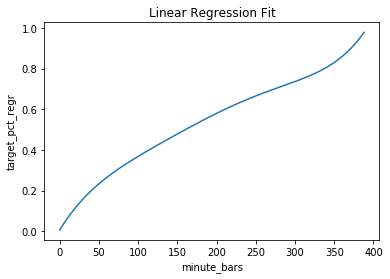

In [10]:
# let's try something different and see what happens...
# bins = np.arange(1, 390)

bins = bar_data['minute_bars'].unique()
target_pct_regr = vwap_target( bins, lm.coef_ )
plt.plot(target_pct_regr)
plt.title('Linear Regression Fit')
plt.xlabel('minute_bars')
plt.ylabel('target_pct_regr')
plt.show()

## Now by binwise averages

In [11]:
# now calculate binwise averages
target_pct_mean = bar_data.groupby( 'minute_bars' ).mean()[ 'accum_pct' ]

## How do they look?

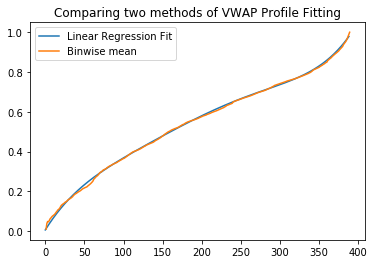

In [12]:
regr_plot = plt.plot( target_pct_regr, label = 'Linear Regression Fit' )
mean_plot = plt.plot( target_pct_mean, label = 'Binwise mean' )
plt.title( 'Comparing two methods of VWAP Profile Fitting' )
plt.legend()
plt.show()

## Let's compare with a single day

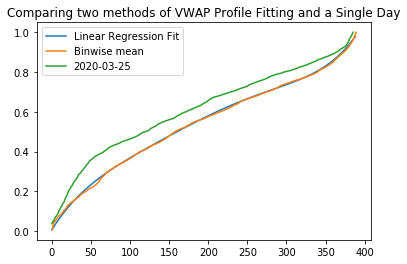

In [13]:
one_day = raw_bar_data[ '2020-03-25' ][ 'accum_pct' ].reset_index( drop = True )

regr_plot = plt.plot( target_pct_regr, label = 'Linear Regression Fit' )
mean_plot = plt.plot( target_pct_mean, label = 'Binwise mean' )
one_day_plot = plt.plot( one_day, label = '2020-03-25' )

plt.title( 'Comparing two methods of VWAP Profile Fitting and a Single Day' )
plt.legend()
plt.show()

## Maybe a different day?

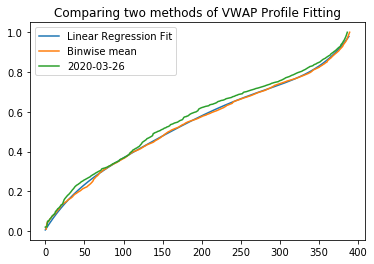

In [14]:
another_day = raw_bar_data[ '2020-03-26' ][ 'accum_pct' ].reset_index( drop = True)

regr_plot = plt.plot( target_pct_regr, label = 'Linear Regression Fit' )
mean_plot = plt.plot( target_pct_mean, label = 'Binwise mean' )
another_day_plot = plt.plot( another_day, label = '2020-03-26' )

plt.title( 'Comparing two methods of VWAP Profile Fitting' )
plt.legend()
plt.show()

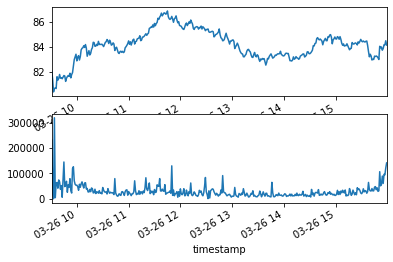

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1)
raw_bar_data[ '2020-03-26' ]['close'].plot(ax=ax1)
raw_bar_data[ '2020-03-26' ]['volume'].plot(ax=ax2)
plt.show()